In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

np.random.seed(42)

# Synthethic Dataset For Experimentation

In [2]:
N_USERS = 50
users = pd.DataFrame({
    'user_id': np.arange(N_USERS),
    'skill_level': np.random.randint(1, 6, N_USERS),  # 1=beginner, 5=expert
    'pref_binary': np.random.rand(N_USERS),
    'pref_multiclass': np.random.rand(N_USERS),
    'pref_segmentation': np.random.rand(N_USERS),
    'pref_detection': np.random.rand(N_USERS),
    'pref_sentiment': np.random.rand(N_USERS),
})

In [3]:
N_TASKS = 200
task_types = ['binary', 'multiclass', 'segmentation', 'detection', 'sentiment']
tasks = pd.DataFrame({
    'task_id': np.arange(N_TASKS),
    'task_type': np.random.choice(task_types, N_TASKS),
    'difficulty': np.random.randint(1,6,N_TASKS),
    'popularity': np.random.exponential(1.0, N_TASKS)  # number of past completions
})

In [4]:
pairs = []
for _ in range(8000):
    u = users.sample(1).iloc[0]
    t = tasks.sample(1).iloc[0]
    
    type_pref = u[f'pref_{t.task_type}']
    skill_diff = u.skill_level - t.difficulty
    score = skill_diff + type_pref + 0.1*np.log1p(t.popularity)
    prob = 1 / (1 + np.exp(-score))
    
    picked = np.random.rand() < prob
    pairs.append((u.user_id, t.task_id, picked, score))

interactions = pd.DataFrame(pairs, columns=['user_id','task_id','picked','true_score'])

## Feature Engineering

In [5]:
df = interactions.merge(users, on='user_id').merge(tasks, on='task_id')

# One-hot task type
for ttype in task_types:
    df[f'is_{ttype}'] = (df['task_type']==ttype).astype(int)

# Interaction features: user preference * task type
for ttype in task_types:
    df[f'pref_x_{ttype}'] = df[f'pref_{ttype}'] * df[f'is_{ttype}']

# Skill difference and log-popularity
df['skill_diff'] = df['skill_level'] - df['difficulty']
df['log_popularity'] = np.log1p(df['popularity'])

FEATURES = ['skill_diff','log_popularity'] + [f'pref_x_{ttype}' for ttype in task_types] + [f'is_{ttype}' for ttype in task_types]
X = df[FEATURES]
y = df['picked'].astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]
print("Toy ranking AUC:", round(roc_auc_score(y_test, y_prob),4))

Toy ranking AUC: 0.8602


In [7]:
def recommend_for_user(user_id, k_candidates=30, top_k=5):
    user = users.loc[users.user_id==user_id].iloc[0]
    candidate_tasks = tasks.sample(k_candidates, replace=False).copy()
    
    # One-hot
    for ttype in task_types:
        candidate_tasks[f'is_{ttype}'] = (candidate_tasks['task_type']==ttype).astype(int)
        candidate_tasks[f'pref_x_{ttype}'] = user[f'pref_{ttype}'] * candidate_tasks[f'is_{ttype}']
    
    candidate_tasks['skill_diff'] = user.skill_level - candidate_tasks['difficulty']
    candidate_tasks['log_popularity'] = np.log1p(candidate_tasks['popularity'])
    
    Xc = candidate_tasks[FEATURES]
    candidate_tasks['score'] = model.predict_proba(Xc)[:,1]
    
    # Diversity boost for less popular tasks
    candidate_tasks['diversity_boost'] = 1.0 / (1.0 + candidate_tasks['popularity'])
    candidate_tasks['final_score'] = candidate_tasks['score'] + 0.1 * candidate_tasks['diversity_boost']
    
    final = candidate_tasks.sort_values('final_score', ascending=False).head(top_k)
    return final[['task_id','task_type','difficulty','score','final_score','popularity']]

# Example: recommend for user 7
rec = recommend_for_user(7)
print("\nTop tasks for user 7:\n", rec.to_string(index=False))


Top tasks for user 7:
  task_id task_type  difficulty    score  final_score  popularity
      10 detection           1 0.941354     1.025739    0.185047
     198    binary           1 0.931355     0.993087    0.619908
     143    binary           1 0.932214     0.989673    0.740376
     144 sentiment           1 0.918570     0.987800    0.444461
      81    binary           1 0.939354     0.969928    2.270751


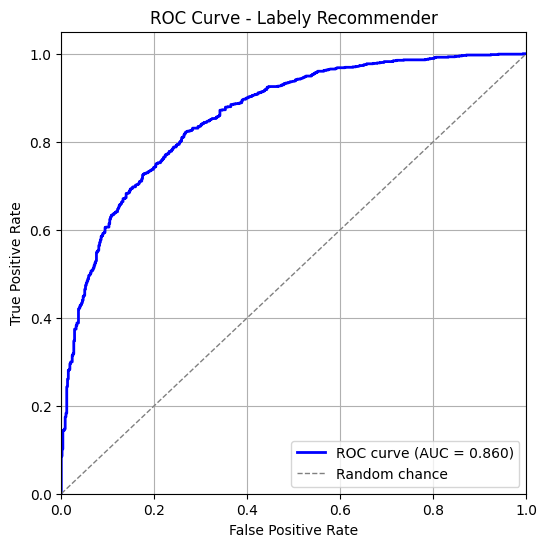

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_test and y_prob are from the model above
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Labely Recommender')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()